<h2> <center><strong>Ecole Polytechnique de Tunisie</strong> </center> </h2> !
<center> <img src="https://nhoues.github.io/Infrastructure-Project/Animations/EPT.jpg" style="width:80px; height:80px"  ></center>


<h1><center>Mini projet conception des systèmes d'information</center></h1>
<h1><em><center>Problème de détection de fraud STEG : Partie préparation des données</em></center></h1>
<h3><center><em>Réalisé par :</em> <font color='blue'> Naim Houes & Malek Mechergui</font></center></h3> 


### Exploration et nettoyage de la data

**Importation des bibliothèques nécessaires à la préparation des données.**

In [1]:
import pandas as pd 
from tqdm.notebook import tqdm 
import gc 
from sklearn import preprocessing
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
client = pd.read_csv('/content/drive/My Drive/colab/CLIENT.csv')
client = pd.DataFrame(data=[ x[0].split() for x in client.values] , columns = client.iloc[0].index[0].split())

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
con1 = pd.read_csv('/content/drive/My Drive/colab/CLIENT_CONSOMMATION_UR60.csv')
con1 = pd.DataFrame(data=[ x[0].split() for x in con1.values] , columns = con1.iloc[0].index[0].split()+['to_drop'])
con1.drop('to_drop',1,inplace = True)
con2 = pd.read_csv('/content/drive/My Drive/colab/CLIENT_CONSOMMATION_UR62.csv')
con2 = pd.DataFrame(data=[ x[0].split() for x in con2.values] , columns = con2.iloc[0].index[0].split()+['to_drop'])
con2.drop('to_drop',1,inplace = True)
con3 = pd.read_csv('/content/drive/My Drive/colab/CLIENT_CONSOMMATION_UR63.csv')
con3 = pd.DataFrame(data=[ x[0].split() for x in con3.values] , columns = con3.iloc[0].index[0].split()+['to_drop'])
con3.drop('to_drop',1,inplace = True)
con4 = pd.read_csv('/content/drive/My Drive/colab/CLIENT_CONSOMMATION_UR69.csv')
con4 = pd.DataFrame(data=[ x[0].split() for x in con4.values] , columns = con4.iloc[0].index[0].split()+['to_drop'])
con4.drop('to_drop',1,inplace = True)
con = pd.concat([con1,con2,con3,con4],ignore_index=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**La base de données des clients**

In [5]:
client.head()

,RC_UR_CODE,CF_AB_CODE,CF_AB_REF,RC_CATEG_CODE,RC_COMMUNE_CODE,CF_AB_DAT_CREATION,CF_AB_SOLDE_FINAL,CF_AB_MENSUALISE,CF_AB_RELANCE,FRAUDE
0,60,BT,000010010,11,0101,15/01/2009,299704,0,1,0
1,60,BT,000010020,11,0101,29/04/2014,0,0,0,0
2,60,BT,000110020,11,0101,23/12/2013,636432,0,1,0
3,60,BT,000110050,51,0101,08/10/2004,523661,0,0,0
4,60,BT,000110070,51,0101,08/10/2008,218691,0,0,0


Supprimer les colonnes inutiles aux traitements, renommer les colonnes restantes plus explicitements et afficher la base de données obtenue.

In [6]:
client.drop(['CF_AB_CODE','CF_AB_SOLDE_FINAL','CF_AB_MENSUALISE','CF_AB_RELANCE'], axis = 1, inplace= True)
col_name = ['district', 'client_id','client_catg','region','creation','Fraud']
client.columns = col_name 
client.head() 

,district,client_id,client_catg,region,creation,Fraud
0,60,000010010,11,0101,15/01/2009,0
1,60,000010020,11,0101,29/04/2014,0
2,60,000110020,11,0101,23/12/2013,0
3,60,000110050,51,0101,08/10/2004,0
4,60,000110070,51,0101,08/10/2008,0


**La base de données des consommations des clients**

In [7]:
con.head()

,CF_AB_CODE,CF_AB_REF,CF_FACT_DATFACT,RC_BTTARIF_CODE,BT_CONSO_NUMCPTR,RC_BT_SCPTR_CODE,RC_CCPTEUR_CODE,RC_BT_ERLV_CODE,BT_CONSO_COEFF,BT_CONSO_CONSO1,BT_CONSO_CONSO2,BT_CONSO_CONSO3,BT_CONSO_CONSO4,BT_CONSO_AINDEX,BT_CONSO_NINDEX,BT_CONSO_NBRMOIS
0,BT,000110050,03/10/2017,11,124416,0,433,9,1,200,100,200,3409,762111,766020,1
1,BT,000110050,05/12/2017,11,124416,0,433,9,1,200,100,200,4327,771442,776269,1
2,BT,000110050,02/02/2018,11,124416,0,433,9,1,200,100,200,3756,779828,784084,1
3,BT,000110050,02/03/2018,11,124416,0,433,9,1,200,100,200,4130,784084,788714,1
4,BT,000110050,03/04/2018,11,124416,0,433,9,1,200,100,200,3732,788714,792946,1


Supprimer les colonnes inutiles aux traitements, renommer les colonnes restantes plus explicitements et afficher la base de données obtenue.

In [8]:
con.drop(["CF_AB_CODE","RC_BT_ERLV_CODE"] , 1 , inplace = True )
cols_name= ['client_id', 'invoice_date','Tarif','counter_number','counter_statue','counter_type','counter_coefficient',
            'consommation_level_1','consommation_level_2','consommation_level_3','consommation_level_4','old_index','new_index','months_number']
            
con.columns = cols_name
con.head()

,client_id,invoice_date,Tarif,counter_number,counter_statue,counter_type,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
0,000110050,03/10/2017,11,124416,0,433,1,200,100,200,3409,762111,766020,1
1,000110050,05/12/2017,11,124416,0,433,1,200,100,200,4327,771442,776269,1
2,000110050,02/02/2018,11,124416,0,433,1,200,100,200,3756,779828,784084,1
3,000110050,02/03/2018,11,124416,0,433,1,200,100,200,4130,784084,788714,1
4,000110050,03/04/2018,11,124416,0,433,1,200,100,200,3732,788714,792946,1


In [9]:
con.dtypes

client_id               object
invoice_date            object
Tarif                   object
counter_number          object
counter_statue          object
counter_type            object
counter_coefficient     object
consommation_level_1    object
consommation_level_2    object
consommation_level_3    object
consommation_level_4    object
old_index               object
new_index               object
months_number           object
dtype: object

On constate que les colonnes sont de type objet donc pour mieux les manipuler on doit faire la conversion.

**Un coup d'oeil sur la distribution de nombre de mois qui séparent deux prises d'index du compteur du client.**

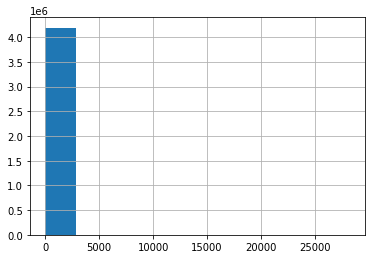

In [10]:
con['months_number'] = con['months_number'].astype('float')
con['months_number'].hist()

On constate un nombre de mois énorme entre deux prises du compteur qui n'est pas confrome à la réalité. Dans la suite du travail, on s'est restreind à 36 mois qui est une durée plus proche de la réalité.

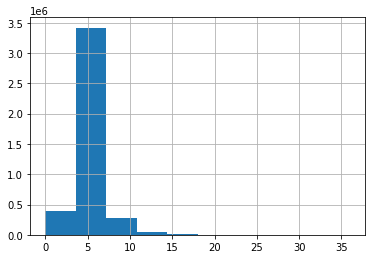

In [11]:
con = con.set_index('counter_number')
con.drop(con[con['months_number']>36].index,inplace=True)
con.reset_index(inplace=True)
con['months_number'].hist()

In [12]:
gc.collect()

0

**Creation de colonne pour la consommation mensuel des clients**

$La \: consommation \: mensuel = (\sum_{i=1}^{4} Consommation \: du \: niveau \:i)/nombre \: de \: mois$

In [0]:
con['consumption_per_month'] =  (con['consommation_level_1'].astype('float') + con['consommation_level_2'].astype('float')+con['consommation_level_3'].astype('float')+con['consommation_level_4'].astype('float')) / con['months_number']

In [14]:
con['consumption_per_month'].describe()

count    4157453.00
mean            inf
std             NaN
min         -379.00
25%           19.00
50%           75.00
75%          166.25
max             inf
Name: consumption_per_month, dtype: float64

La présence de valeurs négatives ou infinies dans les consommations des clients fait qu'on doit éliminer ces dernières (outliers).

In [0]:
con.drop(con[con['consumption_per_month']<0].index,inplace = True)

In [16]:
con[con['consumption_per_month']==np.inf].head()

,counter_number,client_id,invoice_date,Tarif,counter_statue,counter_type,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,consumption_per_month
2048565,j,258925000,30/07/2009,40,coof,0,6,1,0,0,0,0,0,0.0,inf
2048568,j,258925000,03/12/2009,40,coof,5,6,1,0,0,0,0,0,0.0,inf
2051799,j,258925200,30/07/2009,40,cof,0,6,1,0,0,0,0,0,0.0,inf
2051801,j,258925200,05/04/2010,40,cof,0,6,1,0,0,0,0,0,0.0,inf
2051803,j,258925200,28/07/2010,40,cof,0,6,1,0,0,0,0,0,0.0,inf


In [0]:
con = con.set_index('counter_number')
con.drop(con[con['consumption_per_month']==np.inf].index,inplace=True)
con.reset_index(inplace=True)

**Creation de colonne pour indiquer le niveau de consommation**

In [0]:
con['consommation_level_1']=1
con['consommation_level_2']=(con['consommation_level_2'].astype('float')>0.0).astype('int')
con['consommation_level_3']=(con['consommation_level_3'].astype('float')>0.0).astype('int')
con['consommation_level_4']=(con['consommation_level_4'].astype('float')>0.0).astype('int')
con['level'] = con[['consommation_level_1','consommation_level_2','consommation_level_3','consommation_level_4']].sum(axis=1)

In [0]:
con.drop(['consommation_level_1','consommation_level_2','consommation_level_3','consommation_level_4','counter_type','old_index','new_index'],1,inplace=True)

En réalité, les fraudes dans les compteurs de gaz sont très rares donc nous nous sommes concentrés sur les fraudes de l'éléctricité.

In [0]:
#Les compteurs de gaz sont indiqués par un tarif > 29

con['is_Gaz'] = (con['Tarif'].astype('float')>29).astype('int')
con.drop(con[con['is_Gaz']==1].index,inplace=True) 
con.drop('is_Gaz',1,inplace=True)

**Générer des nouveaux features à partir de la date de la dernière facture**

In [0]:
con['invoice_date'] = pd.to_datetime(con['invoice_date'])

con['year'] = con['invoice_date'].dt.year
con['month'] = con['invoice_date'].dt.month
con['quarter'] = con['invoice_date'].dt.quarter

**Un coup d'oeil sur les valeurs manquantes**

In [22]:
#valeurs manquantes dans la dataset de consommation
con.isnull().sum()

counter_number             28
client_id                   0
invoice_date                0
Tarif                       0
counter_statue             28
counter_coefficient        28
months_number            1728
consumption_per_month    1728
level                       0
year                        0
month                       0
quarter                     0
dtype: int64

In [0]:
#se débarasser des colonnes où il manque le nombre des compteurs
con = con.drop(con[con['counter_number'].isnull()].index)

In [0]:
#invoice_date dans un ordre chronoligique
con = con.sort_values('invoice_date')

In [0]:
#conversion du type object vers str (meilleure manipulation)

con['counter_number'] = con['counter_number'].astype(str)
client['client_id'] = client['client_id'].astype(str) 
con['counter_number'] = con['counter_number'].astype(str)

In [26]:
print(client['client_id'].nunique())
print(con['client_id'].nunique())

686576
116076


On constate que dans la dataset des clients il y a beaucoup plus de clients que dans la dataset des consommations des clients. Donc on n'a pas l'historique de consommation de tous les clients.

In [0]:
client = client.set_index('client_id') 
client = client.loc[con['client_id'].unique(),:]

In [28]:
client.head()

,district,client_catg,region,creation,Fraud
client_id,,,,,
001235600,60,11,0101,0,None
001166361,60,11,0101,0,None
001298400,60,11,0101,0,None
001024230,60,11,0101,0,None
001831120,60,11,0101,0,None


In [29]:
client.Fraud.value_counts()

0    98932
1     2554
2       14
3        6
Name: Fraud, dtype: int64

On constate que dans la dataset des clients nous avons des valeurs manquantes ainsi que des valeurs aberrantes dans le champs 'Fraud' qui indique une consommation fradulente ou pas. Ces valeurs sont à éliminer.

In [0]:
client.drop(client[client['Fraud'].isnull()].index,inplace=True)

In [0]:
client['Fraud'] = client['Fraud'].astype('int')
client = client[client['Fraud']<2]

**Le nombre de compteurs de chaque clients**

In [0]:
def how_many_counter(x) : 
  return len(set(x)) 

new = con.groupby('client_id')['counter_number'].agg([how_many_counter])
client = pd.merge(client,new, how = 'left',on = 'client_id')

**Un coup d'oeil sur la distribution des nombres de compteurs pour les clients**

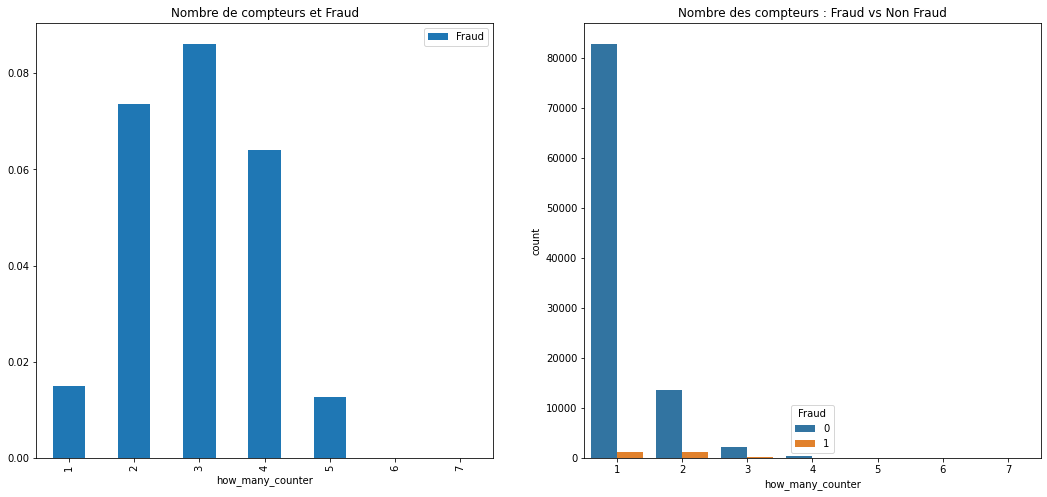

In [33]:
f,ax=plt.subplots(1,2,figsize=(18,8))
client[['how_many_counter','Fraud']].groupby(['how_many_counter']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Nombre de compteurs et Fraud')
sns.countplot('how_many_counter',hue='Fraud',data=client,ax=ax[1])
ax[1].set_title('Nombre des compteurs : Fraud vs Non Fraud')
plt.show()

Malgré que les figures ci dessus montrent que la probabilité de fraud chez un client possedant un seul compteur est la plus faible. On ne va garder que ces clients là (avec un seul compteur). Enfait, la recherche de fraud va se faire par compteur et non pas par client car si un client possède plus qu'un compteur et il est fraudeur, on ne peut pas déterminer si la fraude se passe sur un ou plusieurs compteurs.

In [0]:
client = client[client['how_many_counter']==1]

In [35]:
gc.collect()

0

In [36]:
print(client.index.nunique())
print(con['client_id'].nunique())

84104
116076


En gradeant que les clients possèdant un seul compteur dans la dataset des clients, on garde que ces mêmes clients dans la dataset des consommations pour faire la correspondance.

In [0]:
con = con.set_index('client_id') 
con = con.loc[client.index , : ]

In [0]:
con.reset_index(inplace = True)

#Preparation de la data pour la partie Machine Learning

In [39]:
con[['client_id','counter_number']].nunique()

client_id         84104
counter_number    69687
dtype: int64

On va supprimer les lignes dupliquées pour pouvoir affecter à chaque client le numéro de son compteur dans la base de données des clients

In [0]:
fix_con = con[['client_id','counter_number']].drop_duplicates() 
fix_con.set_index('client_id',inplace = True )
client.loc[fix_con.index , "counter_number"] = fix_con

In [41]:
client.nunique()

district                4
client_catg             3
region                 13
creation             6844
Fraud                   2
how_many_counter        1
counter_number      69687
dtype: int64

In [0]:
client[['district','client_catg','region']] = client[['district','client_catg','region']].astype(int) 
client['creation'] = pd.to_datetime(client['creation'])

In [0]:
client['end'] = con.groupby('client_id')['year'].agg({'max'})
ML_client = client.copy()

In [0]:
ML_client.reset_index(inplace=True)

In [0]:
con = con.set_index('client_id') 
con = con.loc[ML_client['client_id'].unique(),:]

In [46]:
new = con.groupby('client_id')['consumption_per_month'].agg({"mean"})
new.columns = ['mean_consumption']
ML_client = pd.merge(ML_client,new , how ='left' , on ='client_id' )
ML_client.head()

,client_id,district,client_catg,region,creation,Fraud,how_many_counter,counter_number,end,mean_consumption
0,254102051,62,11,301,1977-05-25,0,1,8512846,1978,23.666667
1,253402200,62,11,301,1978-03-01,0,1,8501916,1979,134.800000
2,217932640,69,11,105,1978-10-24,0,1,814057,1979,13.166667
3,253446700,62,11,301,1977-08-11,0,1,8502044,1978,36.750000
4,256224200,62,11,301,1977-11-10,0,1,7991162,1979,32.333333


In [47]:
new = con.groupby('client_id')['consumption_per_month'].agg({"min"})
new.columns = ['min_consumption']
ML_client = pd.merge(ML_client,new , how ='left' , on ='client_id' )
ML_client.head()

,client_id,district,client_catg,region,creation,Fraud,how_many_counter,counter_number,end,mean_consumption,min_consumption
0,254102051,62,11,301,1977-05-25,0,1,8512846,1978,23.666667,1.5
1,253402200,62,11,301,1978-03-01,0,1,8501916,1979,134.800000,125.5
2,217932640,69,11,105,1978-10-24,0,1,814057,1979,13.166667,0.0
3,253446700,62,11,301,1977-08-11,0,1,8502044,1978,36.750000,25.5
4,256224200,62,11,301,1977-11-10,0,1,7991162,1979,32.333333,15.5


In [48]:
new = con.groupby('client_id')['consumption_per_month'].agg({"std"})
new.columns = ['std_consumption']
ML_client = pd.merge(ML_client,new , how ='left' , on ='client_id' )
ML_client.head()

,client_id,district,client_catg,region,creation,Fraud,how_many_counter,counter_number,end,mean_consumption,min_consumption,std_consumption
0,254102051,62,11,301,1977-05-25,0,1,8512846,1978,23.666667,1.5,19.470062
1,253402200,62,11,301,1978-03-01,0,1,8501916,1979,134.800000,125.5,9.915896
2,217932640,69,11,105,1978-10-24,0,1,814057,1979,13.166667,0.0,19.444365
3,253446700,62,11,301,1977-08-11,0,1,8502044,1978,36.750000,25.5,15.909903
4,256224200,62,11,301,1977-11-10,0,1,7991162,1979,32.333333,15.5,19.093629


In [0]:
ML_client['Fraud'] = ML_client['Fraud'].astype('int')

In [50]:
new = con.groupby('client_id')['consumption_per_month'].agg({"max"})
new.columns = ['max_consumption']
ML_client = pd.merge(ML_client,new , how ='left' , on ='client_id' )
ML_client.head()

,client_id,district,client_catg,region,creation,Fraud,how_many_counter,counter_number,end,mean_consumption,min_consumption,std_consumption,max_consumption
0,254102051,62,11,301,1977-05-25,0,1,8512846,1978,23.666667,1.5,19.470062,38.0
1,253402200,62,11,301,1978-03-01,0,1,8501916,1979,134.800000,125.5,9.915896,148.5
2,217932640,69,11,105,1978-10-24,0,1,814057,1979,13.166667,0.0,19.444365,35.5
3,253446700,62,11,301,1977-08-11,0,1,8502044,1978,36.750000,25.5,15.909903,48.0
4,256224200,62,11,301,1977-11-10,0,1,7991162,1979,32.333333,15.5,19.093629,63.0


In [51]:
new = con.groupby(['client_id', 'quarter'])['consumption_per_month'].agg({"mean"})
new.columns = ['mean_quarter_consumption']
new = new.reset_index()
new = new.pivot(index='client_id', columns='quarter', values = 'mean_quarter_consumption')
new.columns = ['mean_quarter'+str(i) for i in range (1,5)]
ML_client = pd.merge(ML_client, new, how ='left', on= 'client_id')
ML_client.head()

,client_id,district,client_catg,region,creation,Fraud,how_many_counter,counter_number,end,mean_consumption,min_consumption,std_consumption,max_consumption,mean_quarter1,mean_quarter2,mean_quarter3,mean_quarter4
0,254102051,62,11,301,1977-05-25,0,1,8512846,1978,23.666667,1.5,19.470062,38.0,NaN,NaN,23.666667,NaN
1,253402200,62,11,301,1978-03-01,0,1,8501916,1979,134.800000,125.5,9.915896,148.5,134.8,NaN,NaN,NaN
2,217932640,69,11,105,1978-10-24,0,1,814057,1979,13.166667,0.0,19.444365,35.5,NaN,0.0,19.750000,NaN
3,253446700,62,11,301,1977-08-11,0,1,8502044,1978,36.750000,25.5,15.909903,48.0,NaN,NaN,25.500000,48.0
4,256224200,62,11,301,1977-11-10,0,1,7991162,1979,32.333333,15.5,19.093629,63.0,NaN,NaN,29.000000,33.0


In [0]:
new = con.groupby(['client_id', 'quarter'])['consumption_per_month'].agg({"min"})
new.columns = ['min_quarter_consumption']
new = new.reset_index()
new = new.pivot(index='client_id', columns='quarter', values = 'min_quarter_consumption')
new.columns = ['min_quarter'+str(i) for i in range (1,5)]
ML_client = pd.merge(ML_client, new, how ='left', on= 'client_id')

In [0]:
new = con.groupby(['client_id', 'quarter'])['consumption_per_month'].agg({"max"})
new.columns = ['max_quarter_consumption']
new = new.reset_index()
new = new.pivot(index='client_id', columns='quarter', values = 'max_quarter_consumption')
new.columns = ['max_quarter'+str(i) for i in range (1,5)]
ML_client = pd.merge(ML_client, new, how ='left', on= 'client_id')

In [54]:
gc.collect()

0

In [55]:
new = con.groupby('client_id')['consumption_per_month'].agg({"count"})
new.columns = ['num_observ']
ML_client = pd.merge(ML_client,new , how ='left' , on ='client_id' )
ML_client.head()

,client_id,district,client_catg,region,creation,Fraud,how_many_counter,counter_number,end,mean_consumption,min_consumption,std_consumption,max_consumption,mean_quarter1,mean_quarter2,mean_quarter3,mean_quarter4,min_quarter1,min_quarter2,min_quarter3,min_quarter4,max_quarter1,max_quarter2,max_quarter3,max_quarter4,num_observ
0,254102051,62,11,301,1977-05-25,0,1,8512846,1978,23.666667,1.5,19.470062,38.0,NaN,NaN,23.666667,NaN,NaN,NaN,1.5,NaN,NaN,NaN,38.0,NaN,3
1,253402200,62,11,301,1978-03-01,0,1,8501916,1979,134.800000,125.5,9.915896,148.5,134.8,NaN,NaN,NaN,125.5,NaN,NaN,NaN,148.5,NaN,NaN,NaN,5
2,217932640,69,11,105,1978-10-24,0,1,814057,1979,13.166667,0.0,19.444365,35.5,NaN,0.0,19.750000,NaN,NaN,0.0,4.0,NaN,NaN,0.0,35.5,NaN,3
3,253446700,62,11,301,1977-08-11,0,1,8502044,1978,36.750000,25.5,15.909903,48.0,NaN,NaN,25.500000,48.0,NaN,NaN,25.5,48.0,NaN,NaN,25.5,48.0,2
4,256224200,62,11,301,1977-11-10,0,1,7991162,1979,32.333333,15.5,19.093629,63.0,NaN,NaN,29.000000,33.0,NaN,NaN,29.0,15.5,NaN,NaN,29.0,63.0,6


In [0]:
ML_client = ML_client[ML_client['num_observ']>5]

In [0]:
ML_client.loc[ML_client[ML_client['mean_quarter1'].isnull()].index, 'mean_quarter1'] = ML_client.loc[ML_client[ML_client['mean_quarter1'].isnull()].index, 'mean_consumption']
ML_client.loc[ML_client[ML_client['mean_quarter2'].isnull()].index, 'mean_quarter2'] = ML_client.loc[ML_client[ML_client['mean_quarter2'].isnull()].index, 'mean_consumption']
ML_client.loc[ML_client[ML_client['mean_quarter3'].isnull()].index, 'mean_quarter3'] = ML_client.loc[ML_client[ML_client['mean_quarter3'].isnull()].index, 'mean_consumption']
ML_client.loc[ML_client[ML_client['mean_quarter4'].isnull()].index, 'mean_quarter4'] = ML_client.loc[ML_client[ML_client['mean_quarter4'].isnull()].index, 'mean_consumption']


In [0]:
ML_client.loc[ML_client[ML_client['max_quarter1'].isnull()].index, 'max_quarter1'] = ML_client.loc[ML_client[ML_client['max_quarter1'].isnull()].index, 'max_consumption']
ML_client.loc[ML_client[ML_client['max_quarter2'].isnull()].index, 'max_quarter2'] = ML_client.loc[ML_client[ML_client['max_quarter2'].isnull()].index, 'max_consumption']
ML_client.loc[ML_client[ML_client['max_quarter3'].isnull()].index, 'max_quarter3'] = ML_client.loc[ML_client[ML_client['max_quarter3'].isnull()].index, 'max_consumption']
ML_client.loc[ML_client[ML_client['max_quarter4'].isnull()].index, 'max_quarter4'] = ML_client.loc[ML_client[ML_client['max_quarter4'].isnull()].index, 'max_consumption']


In [0]:
ML_client.loc[ML_client[ML_client['min_quarter1'].isnull()].index, 'min_quarter1'] = ML_client.loc[ML_client[ML_client['min_quarter1'].isnull()].index, 'min_consumption']
ML_client.loc[ML_client[ML_client['min_quarter2'].isnull()].index, 'min_quarter2'] = ML_client.loc[ML_client[ML_client['min_quarter2'].isnull()].index, 'min_consumption']
ML_client.loc[ML_client[ML_client['min_quarter3'].isnull()].index, 'min_quarter3'] = ML_client.loc[ML_client[ML_client['min_quarter3'].isnull()].index, 'min_consumption']
ML_client.loc[ML_client[ML_client['min_quarter4'].isnull()].index, 'min_quarter4'] = ML_client.loc[ML_client[ML_client['min_quarter4'].isnull()].index, 'min_consumption']


In [60]:
new = con.groupby('client_id')['consumption_per_month'].agg({"var"})
new.columns = ['var_consumption']
ML_client = pd.merge(ML_client,new , how ='left' , on ='client_id' )
ML_client.head()

,client_id,district,client_catg,region,creation,Fraud,how_many_counter,counter_number,end,mean_consumption,min_consumption,std_consumption,max_consumption,mean_quarter1,mean_quarter2,mean_quarter3,mean_quarter4,min_quarter1,min_quarter2,min_quarter3,min_quarter4,max_quarter1,max_quarter2,max_quarter3,max_quarter4,num_observ,var_consumption
0,256224200,62,11,301,1977-11-10,0,1,7991162,1979,32.333333,15.5,19.093629,63.0,32.333333,32.333333,29.0,33.0,15.5,15.5,29.0,15.5,63.0,63.0,29.0,63.0,6,364.566667
1,217390400,69,11,107,1978-04-08,0,1,350923,1980,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0.000000
2,254832200,62,11,301,1979-12-11,0,1,8626937,1981,33.500000,2.5,36.313909,102.5,33.500000,33.500000,29.0,34.4,2.5,2.5,29.0,2.5,102.5,102.5,29.0,102.5,6,1318.700000
3,254831100,62,11,301,1979-07-26,0,1,8630278,1981,70.583333,50.0,21.329362,98.0,70.583333,70.583333,72.0,70.3,50.0,50.0,72.0,50.0,98.0,98.0,72.0,98.0,6,454.941667
4,000850400,60,11,101,1980-04-09,0,1,1255468,1982,41.000000,20.0,35.959700,113.0,46.625000,29.750000,41.0,41.0,20.0,20.5,20.0,20.0,113.0,39.0,113.0,113.0,6,1293.100000


In [61]:
ML_client.isnull().sum().sum()

0

In [0]:
def q75(x) : 
    return x.quantile(0.75)
def q25(x) : 
    return x.quantile(0.25)
def q10(x) : 
    return x.quantile(0.1)
def q90(x) : 
    return x.quantile(0.90)

In [0]:
new = con.groupby('client_id')['consumption_per_month'].agg([q25])
new.columns = ['q25']
ML_client = pd.merge(ML_client,new , how ='left' , on ='client_id' )

In [64]:
gc.collect()

0

In [0]:
new = con.groupby('client_id')['consumption_per_month'].agg([q75])
new.columns = ['q75']
ML_client = pd.merge(ML_client,new , how ='left' , on ='client_id' )

In [66]:
gc.collect()

0

In [0]:
new = con.groupby('client_id')['consumption_per_month'].agg([q10])
new.columns = ['q10']
ML_client = pd.merge(ML_client,new , how ='left' , on ='client_id' )

In [68]:
gc.collect()

0

In [0]:
new = con.groupby('client_id')['consumption_per_month'].agg([q90])
new.columns = ['q90']
ML_client = pd.merge(ML_client,new , how ='left' , on ='client_id' )

Des indicateurs de la fluctuation de la consommation des client

In [0]:
ML_client['Range_consump']=2*(ML_client['max_consumption']-ML_client['min_consumption'])/(ML_client['max_consumption']+ML_client['min_consumption'])
ML_client['Q']=0.5*(ML_client['q75'] - ML_client['q25'])
ML_client['CD']=(ML_client['q75']-ML_client['q25'])/(ML_client['q75']+ML_client['q25'])
ML_client['BSD']=ML_client['std_consumption']/ML_client['mean_consumption']
ML_client['VD']=ML_client['var_consumption']/ML_client['mean_consumption']
ML_client['CDq']=(ML_client['q90']-ML_client['q10'])/(ML_client['q90']+ML_client['q10'])

In [71]:
gc.collect()

39

In [0]:
ML_client.drop(ML_client[ML_client['CDq'].isnull()].index, inplace=True)

In [0]:
ML_client.drop(ML_client[ML_client['CD'].isnull()].index, inplace=True)

In [74]:
gc.collect()

0

In [75]:
ML_client.isnull().sum().sum()

0

#Preparation de la data pour la partie Deep Learning

In [0]:
ML_client = ML_client.set_index('client_id')
con = con.loc[ML_client.index,:]
con = con.reset_index()

Prétraitements sur les features de la sequence de consommation.

In [0]:
#Data preprocessing 
fix_columns = ['year','month','level','quarter','months_number']
for f in fix_columns : 
  label_encoder = preprocessing.LabelEncoder()
  label_encoder.fit(con[f].astype('str'))
  con[f] = label_encoder.transform(con[f].astype('str').fillna('-1'))

In [0]:
num_features = 'consumption_per_month'
scale = preprocessing.MinMaxScaler()
scale.fit(con[num_features].values.reshape(-1,1))
con[num_features] = scale.transform(con[num_features].values.reshape(-1,1))

In [79]:
tqdm.pandas()
grouped = con.groupby('client_id',as_index = False)
grouped_compteur_number = grouped.progress_apply(lambda x: x.reset_index(drop = True)).reset_index()
grouped_compteur_number['columns'] = 'seq(t= ' + grouped_compteur_number['level_1'].astype('str')+ ')'

Nous avons générer des nouveaux features qui décrivent la consommation par mois de chaque client décalée de ± 3 observations ainsi des indicateurs statistiques sur cette consommation par mois.

In [0]:
windows = [1,2,3]
for window in windows:    
  grouped_compteur_number['consumption_shift_pos_' + str(window)] = grouped_compteur_number.groupby('client_id')['consumption_per_month'].shift(window).fillna(0)
  grouped_compteur_number['consumption_shift_neg_' + str(window)] = grouped_compteur_number.groupby('client_id')['consumption_per_month'].shift(-1 * window).fillna(0)

In [0]:
feat = ['consumption_shift_neg_' + str(window) for window in windows ] + ['consumption_per_month'] + ['consumption_shift_pos_' + str(window) for window in windows ]
grouped_compteur_number['mean_lag'] = grouped_compteur_number[feat].mean(axis = 1 )
grouped_compteur_number['max_lag'] = grouped_compteur_number[feat].max(axis = 1 )
grouped_compteur_number['min_lag'] =grouped_compteur_number[feat].min(axis = 1 )
grouped_compteur_number['std_lag'] = grouped_compteur_number[feat].std(axis = 1 )
grouped_compteur_number['var_lag'] = grouped_compteur_number[feat].var(axis = 1 )

In [0]:
new = grouped_compteur_number.groupby('client_id')['level_1'].agg('count')
new = new.reset_index()
new.columns = ['client_id','seq_len']
grouped_compteur_number = pd.merge(grouped_compteur_number,new , how ='left',on='client_id')

In [83]:
final_data_deep_model = grouped_compteur_number.pivot(index='client_id',columns='columns',values=['consumption_per_month','level','quarter','months_number','mean_lag','max_lag','min_lag','std_lag','var_lag']) 
final_data_deep_model.head()

consumption_per_month            ...    var_lag           
columns               seq(t= 0) seq(t= 1)  ... seq(t= 98) seq(t= 99)
client_id                                  ...                      
000110050              0.024840  0.027990  ...    0.00001   0.000008
000110070              0.000067  0.015666  ...        NaN        NaN
000112401              0.003004  0.002772  ...        NaN        NaN
000112451              0.002959  0.003105  ...        NaN        NaN
000112501              0.002320  0.002493  ...        NaN        NaN

[5 rows x 1431 columns]

In [84]:
grouped_compteur_number = grouped_compteur_number.set_index('client_id')
grouped_compteur_number = grouped_compteur_number.loc[ML_client.index,:]
grouped_compteur_number  = grouped_compteur_number.reset_index()
ML_client = ML_client.reset_index()
DL_client = grouped_compteur_number[['client_id','counter_coefficient','Tarif','seq_len']].drop_duplicates()
DL_client['counter_coefficient'] = DL_client['counter_coefficient'].astype(float)
DL_client['Tarif'] = DL_client['Tarif'].astype(float)
DL_client = DL_client.groupby('client_id')[['counter_coefficient','Tarif','seq_len']].agg('max')
DL_client = DL_client.reset_index()
ML_client = ML_client.set_index('client_id')
ML_client = ML_client.loc[DL_client['client_id'].unique(),:]
DL_client = DL_client.set_index('client_id')
DL_client = pd.concat([ML_client,DL_client],axis=1)
final_data_deep_model = pd.concat([final_data_deep_model,DL_client],axis=1)
final_data_deep_model.head()

,"(consumption_per_month, seq(t= 0))","(consumption_per_month, seq(t= 1))","(consumption_per_month, seq(t= 10))","(consumption_per_month, seq(t= 100))","(consumption_per_month, seq(t= 101))","(consumption_per_month, seq(t= 102))","(consumption_per_month, seq(t= 103))","(consumption_per_month, seq(t= 104))","(consumption_per_month, seq(t= 105))","(consumption_per_month, seq(t= 106))","(consumption_per_month, seq(t= 107))","(consumption_per_month, seq(t= 108))","(consumption_per_month, seq(t= 109))","(consumption_per_month, seq(t= 11))","(consumption_per_month, seq(t= 110))","(consumption_per_month, seq(t= 111))","(consumption_per_month, seq(t= 112))","(consumption_per_month, seq(t= 113))","(consumption_per_month, seq(t= 114))","(consumption_per_month, seq(t= 115))","(consumption_per_month, seq(t= 116))","(consumption_per_month, seq(t= 117))","(consumption_per_month, seq(t= 118))","(consumption_per_month, seq(t= 119))","(consumption_per_month, seq(t= 12))","(consumption_per_month, seq(t= 120))","(consumption_per_month, seq(t= 121))","(consumption_per_month, seq(t= 122))","(consumption_per_month, seq(t= 123))","(consumption_per_month, seq(t= 124))","(consumption_per_month, seq(t= 125))","(consumption_per_month, seq(t= 126))","(consumption_per_month, seq(t= 127))","(consumption_per_month, seq(t= 128))","(consumption_per_month, seq(t= 129))","(consumption_per_month, seq(t= 13))","(consumption_per_month, seq(t= 130))","(consumption_per_month, seq(t= 131))","(consumption_per_month, seq(t= 132))","(consumption_per_month, seq(t= 133))",...,"(var_lag, seq(t= 99))",district,client_catg,region,creation,Fraud,how_many_counter,counter_number,end,mean_consumption,min_consumption,std_consumption,max_consumption,mean_quarter1,mean_quarter2,mean_quarter3,mean_quarter4,min_quarter1,min_quarter2,min_quarter3,min_quarter4,max_quarter1,max_quarter2,max_quarter3,max_quarter4,num_observ,var_consumption,q25,q75,q10,q90,Range_consump,Q,CD,BSD,VD,CDq,counter_coefficient,Tarif,seq_len
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000110050,0.024840,0.027990,0.054526,0.023873,0.022863,0.022956,0.021163,0.015219,0.016467,0.016571,0.021366,0.019474,0.019485,0.046719,0.023757,0.017953,0.01595,0.021261,0.023531,0.024849,0.023757,0.031471,0.018609,0.021128,0.034524,0.022689,0.027362,0.021383,0.025824,0.028018,0.024703,0.026874,0.025963,0.025222,0.020658,0.045767,0.024564,0.026166,0.023972,0.027489,...,0.000008,60,51,101,2004-08-10,0,1,124416,2019,4600.844807,0.000,1897.136498,14303.00,4436.192593,4987.448864,4487.833333,2748.000000,0.000,1053.0,4279.500,2748.000,10021.00,14303.00,4699.0,2748.00,138,3.599127e+06,3576.0000,4854.0000,3009.50,7140.025,2.000000,639.0000,0.151601,0.412345,782.275222,0.406967,1.0,11.0,138
000110070,0.000067,0.015666,0.012381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012613,NaN,NaN,NaN,NaN,...,NaN,60,51,101,2008-08-10,0,1,171147,2019,2745.472222,0.000,941.154713,5487.00,2762.645480,2687.744444,3016.166667,2652.000000,0.000,683.0,2534.000,2652.000,5021.00,5487.00,3637.0,2652.00,93,8.857722e+05,2289.0000,3209.0000,1868.00,3630.800,2.000000,460.0000,0.167334,0.342802,322.630179,0.320579,1.0,11.0,93
000112401,0.003004,0.002772,0.002927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002378,NaN,NaN,NaN,NaN,...,NaN,60,11,101,2000-07-20,0,1,300317,2019,441.000000,185.500,67.418522,541.00,452.067308,423.250000,452.625000,441.000000,410.500,185.5,348.500,185.500,540.25,509.50,541.0,541.00,36,4.545257e+03,410.3125,478.9375,371.75,511.625,0.978665,34.3125,0.077172,0.152876,10.306706,0.158342,1.0,11.0,36
000112451,0.002959,0.003105,0.003565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002243,NaN,NaN,NaN,NaN,...,NaN,60,11,1

In [85]:
final_data_deep_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64853 entries, 000110050 to 258982002
Columns: 1470 entries, ('consumption_per_month', 'seq(t= 0)') to seq_len
dtypes: datetime64[ns](1), float64(1460), int64(8), object(1)
memory usage: 727.8+ MB


# Train Test split 

In [0]:
from sklearn.model_selection import train_test_split
train_client , test_client  = train_test_split(ML_client,test_size = 0.2 , random_state=42 , stratify = ML_client['Fraud'].values)

In [0]:
DL_train_client = final_data_deep_model.loc[train_client.index , : ]
DL_test_client = final_data_deep_model.loc[test_client.index , : ]

In [0]:
train_client.to_csv('/content/drive/My Drive/colab/train_client.csv')
test_client.to_csv('/content/drive/My Drive/colab/test_client.csv')
DL_train_client.to_csv('/content/drive/My Drive/colab/DL_train_client.csv')
DL_test_client.to_csv('/content/drive/My Drive/colab/DL_test_client.csv')

In [89]:
gc.collect()

3